# INF8111 - Fouille de données


## TP2 Automne 2019 - Détection de discours d'incitation à la haine

##### Membres de l'équipe:

    - MAINKA Adrien (2046374)
    - BAKKAOUI Mehdi (2038803)
    - METAIS Marianne (2038757)

In [2]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
import words_repeated_char
import sys
import pickle

## 1. importation des données (après Preprocessing)

In [3]:
file = open("data/preprocess_balanced.pkl",'rb')
preprocessed = pickle.load(file) #C'est une "balanced database"  i.e qu'il y autant d'exemples pour chacune des classes.
file.close()

In [4]:
preprocessed.head()

,tweet,label
0,"[yall, nigga, stop, dick, riding, ..., you, ai...",1
1,"[i, put, my, iphone, in, my, pocket, with, scr...",0
2,"[wait, until, you, learn, that, the, u, rescue...",0
3,"[we, 're, dead, ., we, 're, all, dead, ., well...",0
4,"[what, could, USER, have, in, store, ?, follow...",3


## 2. Jeu de données

In [5]:
from sklearn.model_selection import train_test_split

X = preprocessed['tweet']
y = preprocessed['label']

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, y, test_size=0.15, random_state=12)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_valid_X, train_valid_Y, test_size=0.18, random_state=12)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))
print("Length of test set : ", len(test_X))

Length of training set :  10560
Length of validation set :  2319
Length of test set :  2273


## 3. Stemming

In [6]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, tweet):
        """
        tweet: a list of string
        """
        # Have to return the stemmed tweet
        return list(map(self.stemmer.stem , tweet))

In [7]:
s=Stemmer()
X = list(map(s.stem, X))

## 4. Classification

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


def train_evaluate(classifier, training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    classifier: model used (LogisticRegression...)
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    target_names = ['hateful', 'abusive', 'spam','normal']
    
    training_rep = bowObj.fit_transform(training_X)

    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validation_Y_pred = classifier.predict(bowObj.transform(validation_X))
    validationAcc = accuracy_score(validation_Y, validation_Y_pred)
    
    properties = classification_report(validation_Y, validation_Y_pred, target_names=target_names)

    return classifier, trainAcc, validationAcc, properties

In [19]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def function(token):
    return token

def model_comparison(classifier, nom_classifier):
    """
    classifier: model used (LogisticRegression...)
    nom_classifier: model name
    
    :return: Comparison of the classifier with CountBoW, TF-IDF, unigram and bigram.
    """
    
    trainAcc = []
    validationAcc = []

    # 1.classifier + CountBoW + unigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, cv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])
    print('\033[1m\033[91m'+nom_classifier+' with CountBoW and unigram :'+'\033[0m')
    print(model[3]+'\n')

    # 2.classifier + CountBoW + unigram + bigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, cv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])
    print('\033[1m\033[91m'+nom_classifier+' with CountBoW, unigram and bigram :'+'\033[0m')
    print(model[3]+'\n')

    # 3.classifier + TF-IDF + unigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, tv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])
    print('\033[1m\033[91m'+nom_classifier+' with TF-IDF and unigram :'+'\033[0m')
    print(model[3]+'\n')

    # 4.classifier + TF-IDF + unigram + bigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, tv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])
    print('\033[1m\033[91m'+nom_classifier+' with TF-IDF, unigram and bigram :'+'\033[0m')
    print(model[3])
    
    # Graphe de comparaison des différents modèles
    
    r=np.arange(len(trainAcc))
    
    TypeAcc = ["Training", "Validation"]
    models_names = ['CountBoW \nunigram', 'CountBoW \nunigram \nbigram', 
     'TF-IDF \nunigram', 'TF-IDF \nunigram \nbigram']
    bar_width = 0.4

    plt.bar(r, trainAcc,bar_width)
    plt.bar(r+bar_width, validationAcc,bar_width)
    plt.xticks(r+bar_width/2, models_names, rotation=0)

    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')

    plt.title(nom_classifier)

    plt.legend(TypeAcc)

    for i in range(len(trainAcc)):
        plt.text(x = r[i]-bar_width/2 , y = trainAcc[i]+0.01, s = '%.4f' % trainAcc[i])
        plt.text(x = r[i]+bar_width/2 , y = validationAcc[i]+0.01, s = '%.4f' % validationAcc[i])

    plt.ylim(.5, 1.2)
    plt.show()

### 5.1 Modèles linéaires

#### 5.1.1 Régression logistique

LogisticRegression with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.59      0.53      0.56       550
     abusive       0.73      0.76      0.75       558
        spam       0.58      0.49      0.53       618
      normal       0.66      0.80      0.72       593

   micro avg       0.64      0.64      0.64      2319
   macro avg       0.64      0.64      0.64      2319
weighted avg       0.64      0.64      0.64      2319


LogisticRegression with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.59      0.52      0.55       550
     abusive       0.74      0.76      0.75       558
        spam       0.59      0.49      0.53       618
      normal       0.66      0.83      0.74       593

   micro avg       0.65      0.65      0.65      2319
   macro avg       0.64      0.65      0.64      2319
weighted avg       0.64      0.65      0.64      2319


LogisticRegression with TF

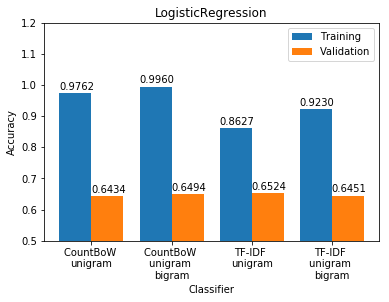

In [20]:
from sklearn.linear_model import LogisticRegression

model_comparison(LogisticRegression(),'LogisticRegression')

#### 5.1.2 Stochastic Gradient Descent

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.54      0.58      0.56       550
     abusive       0.74      0.66      0.70       558
        spam       0.59      0.36      0.45       618
      normal       0.58      0.83      0.68       593

   micro avg       0.61      0.61      0.61      2319
   macro avg       0.61      0.61      0.60      2319
weighted avg       0.61      0.61      0.59      2319


SGDClassifier with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.58      0.46      0.52       550
     abusive       0.69      0.79      0.74       558
        spam       0.57      0.44      0.50       618
      normal       0.64      0.83      0.72       593

   micro avg       0.63      0.63      0.63      2319
   macro avg       0.62      0.63      0.62      2319
weighted avg       0.62      0.63      0.62      2319


SGDClassifier with TF-IDF and unigra

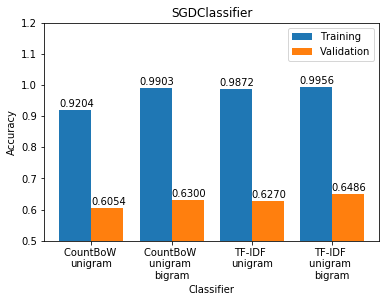

In [21]:
from sklearn.linear_model import SGDClassifier

model_comparison(SGDClassifier(),'SGDClassifier')

#### 5.1.3 Perceptron

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Perceptron with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.57      0.51      0.53       550
     abusive       0.71      0.75      0.73       558
        spam       0.55      0.44      0.49       618
      normal       0.62      0.77      0.68       593

   micro avg       0.61      0.61      0.61      2319
   macro avg       0.61      0.62      0.61      2319
weighted avg       0.61      0.61      0.61      2319


Perceptron with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.55      0.56      0.56       550
     abusive       0.65      0.78      0.71       558
        spam       0.53      0.38      0.44       618
      normal       0.68      0.74      0.71       593

   micro avg       0.61      0.61      0.61      2319
   macro avg       0.61      0.62      0.61      2319
weighted avg       0.60      0.61      0.60      2319


Perceptron with TF-IDF and unigram :
     

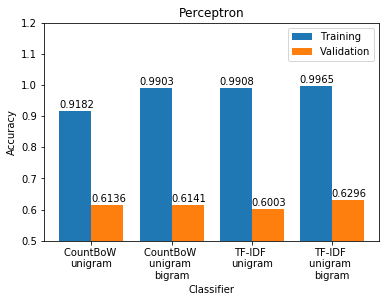

In [22]:
from sklearn.linear_model import Perceptron

model_comparison(Perceptron(),'Perceptron')

#### 5.1.4 PassiveAggressiveClassifier

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


PassiveAggressiveClassifier with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.55      0.59      0.57       550
     abusive       0.72      0.73      0.72       558
        spam       0.59      0.39      0.47       618
      normal       0.63      0.80      0.71       593

   micro avg       0.63      0.63      0.63      2319
   macro avg       0.62      0.63      0.62      2319
weighted avg       0.62      0.63      0.62      2319


PassiveAggressiveClassifier with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.58      0.53      0.56       550
     abusive       0.71      0.77      0.74       558
        spam       0.57      0.46      0.51       618
      normal       0.66      0.80      0.72       593

   micro avg       0.64      0.64      0.64      2319
   macro avg       0.63      0.64      0.63      2319
weighted avg       0.63      0.64      0.63      2319


PassiveA

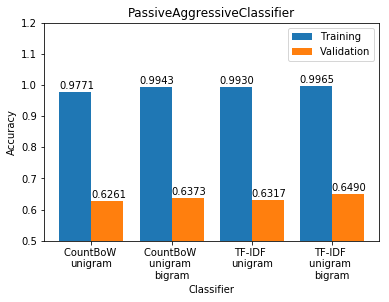

In [23]:
from sklearn.linear_model import PassiveAggressiveClassifier

model_comparison(PassiveAggressiveClassifier(),'PassiveAggressiveClassifier')

### 5.2 Support Vector Machines 

#### 5.2.1  Linear Support Vector Classification

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear Support Vector Classification with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.56      0.52      0.54       550
     abusive       0.67      0.75      0.71       558
        spam       0.56      0.45      0.50       618
      normal       0.66      0.76      0.70       593

   micro avg       0.62      0.62      0.62      2319
   macro avg       0.61      0.62      0.61      2319
weighted avg       0.61      0.62      0.61      2319


Linear Support Vector Classification with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.57      0.52      0.54       550
     abusive       0.70      0.76      0.73       558
        spam       0.58      0.44      0.50       618
      normal       0.65      0.81      0.72       593

   micro avg       0.63      0.63      0.63      2319
   macro avg       0.63      0.63      0.62      2319
weighted avg       0.62      0.63      0.62   

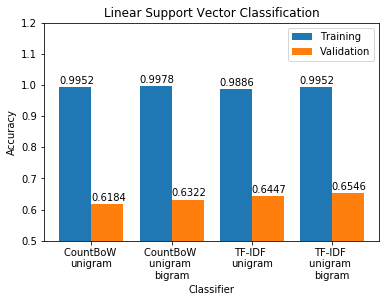

In [24]:
from sklearn.svm import LinearSVC 

model_comparison(LinearSVC(),'Linear Support Vector Classification')

### 5.3 Decision Trees

DecisionTreeClassifier with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.49      0.47      0.48       550
     abusive       0.72      0.72      0.72       558
        spam       0.47      0.39      0.43       618
      normal       0.61      0.74      0.67       593

   micro avg       0.58      0.58      0.58      2319
   macro avg       0.57      0.58      0.57      2319
weighted avg       0.57      0.58      0.57      2319


DecisionTreeClassifier with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.48      0.46      0.47       550
     abusive       0.75      0.71      0.73       558
        spam       0.48      0.39      0.43       618
      normal       0.60      0.77      0.68       593

   micro avg       0.58      0.58      0.58      2319
   macro avg       0.58      0.58      0.58      2319
weighted avg       0.58      0.58      0.57      2319


DecisionTreeClassi

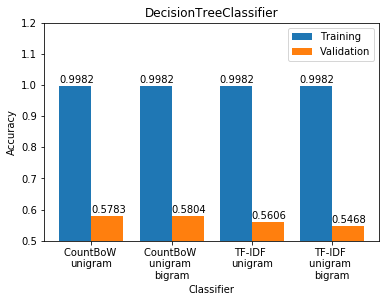

In [25]:
from sklearn.tree import DecisionTreeClassifier

model_comparison(DecisionTreeClassifier(),'DecisionTreeClassifier')